In [61]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

from scipy.spatial.distance import cdist

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

plot_kwds={'alpha':0.25, 's':20, 'linewidths':0}
palette = sns.color_palette('deep', 12)

In [62]:
Dataset  = pd.read_csv('SampleS1.txt',sep='\t')

In [63]:
X_position = Dataset.X
Y_position = Dataset.Y
A_amplitude = Dataset.A

In [64]:
X_position_cl = X_position[np.where(A_amplitude>0)[0]]
Y_position_cl = Y_position[np.where(A_amplitude>0)[0]]
A_amplitude_cl = A_amplitude[np.where(A_amplitude>0)[0]]

In [65]:
Data_use = np.vstack([X_position_cl,A_amplitude_cl]).T

Text(0,0.5,'Amplitude')

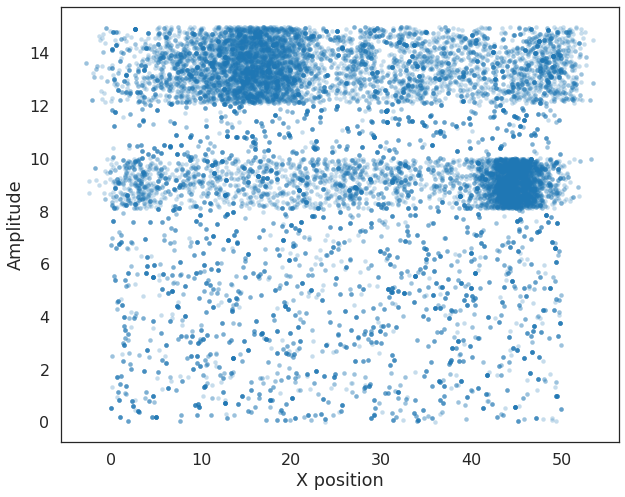

In [66]:
plt.figure(figsize=(10,8))
plt.scatter(X_position_cl,A_amplitude_cl,**plot_kwds)
plt.xlabel('X position')
plt.ylabel('Amplitude')

In [67]:
import hdbscan

In [68]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=250,gen_min_span_tree=False,min_samples=450)
clusterer.fit(Data_use)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=250, min_samples=450, p=None,
    prediction_data=False)

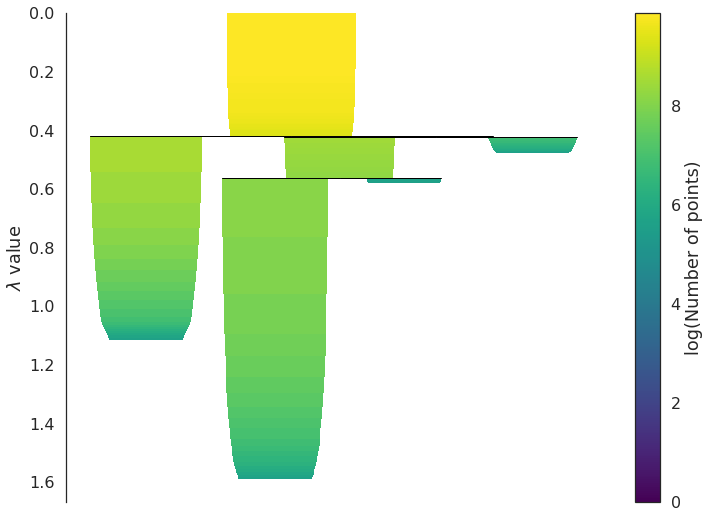

In [77]:
plt.figure(figsize=(12,9))
clusterer.condensed_tree_.plot(log_size=True)

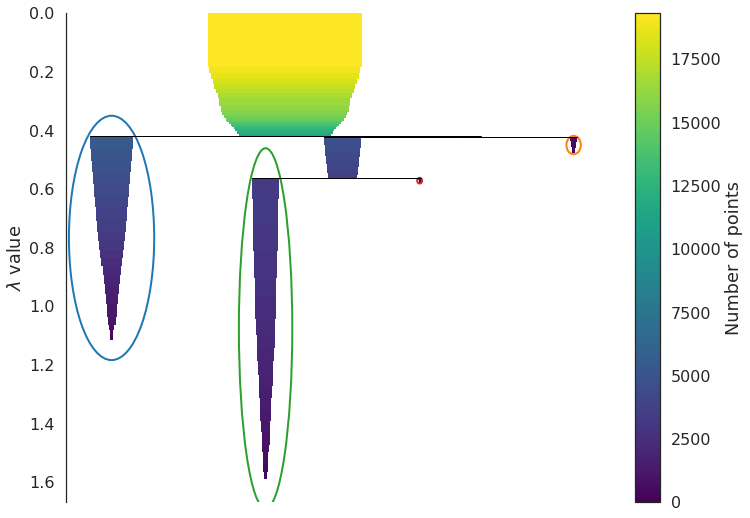

In [78]:
plt.figure(figsize=(12,9))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

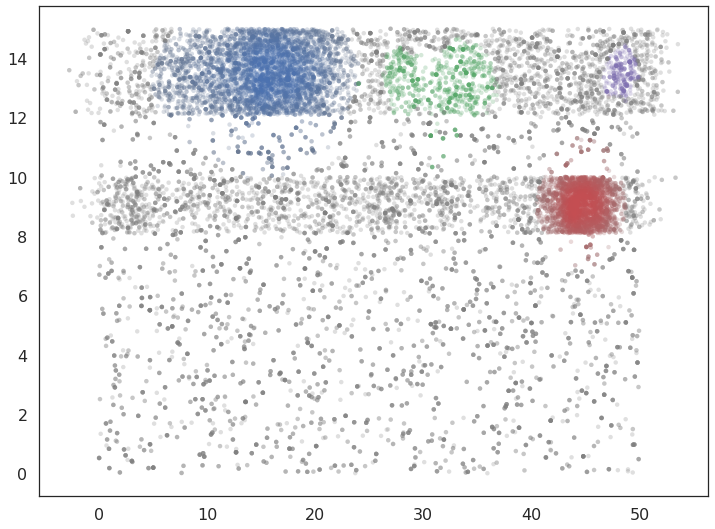

In [79]:
plt.figure(figsize=(12,9))

pal = sns.color_palette('deep', 8)
cluster_colors = [sns.desaturate(pal[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(X_position_cl, A_amplitude_cl, c=cluster_colors, **plot_kwds)

# Soft clustering

In [72]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) & 
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

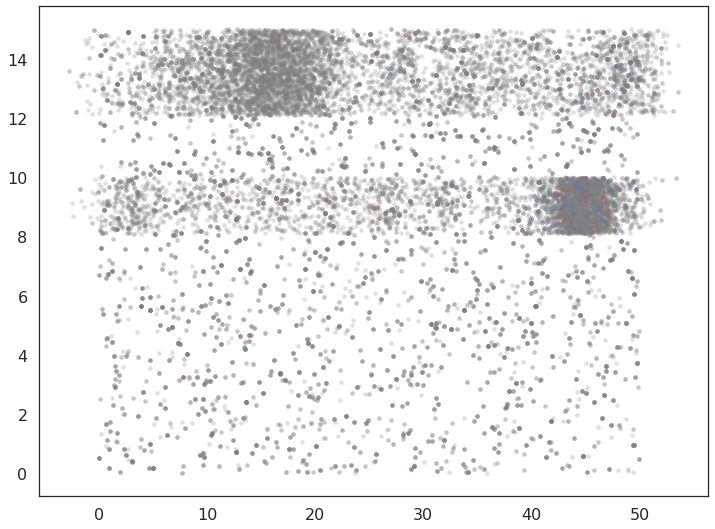

In [80]:
plt.figure(figsize=(12,9))
tree = clusterer.condensed_tree_
plt.scatter(X_position_cl, A_amplitude_cl, c='grey', **plot_kwds)
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    plt.scatter(X_position_cl[c_exemplars], A_amplitude_cl[c_exemplars], c=palette[i], **plot_kwds)

In [81]:
def min_dist_to_exemplar(point, cluster_exemplars, data):
    dists = cdist([data[point]], data[cluster_exemplars.astype(np.int32)])
    return dists.min()

def dist_vector(point, exemplar_dict, data):
    result = {}
    for cluster in exemplar_dict:
        result[cluster] = min_dist_to_exemplar(point, exemplar_dict[cluster], data)
    return np.array(list(result.values()))
    
def dist_membership_vector(point, exemplar_dict, data, softmax=False):
    if softmax:
        result = np.exp(1./dist_vector(point, exemplar_dict, data))
        result[~np.isfinite(result)] = np.finfo(np.double).max
    else:
        result = 1./dist_vector(point, exemplar_dict, data)
        result[~np.isfinite(result)] = np.finfo(np.double).max
    result /= result.sum()
    return result

/home/hope/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


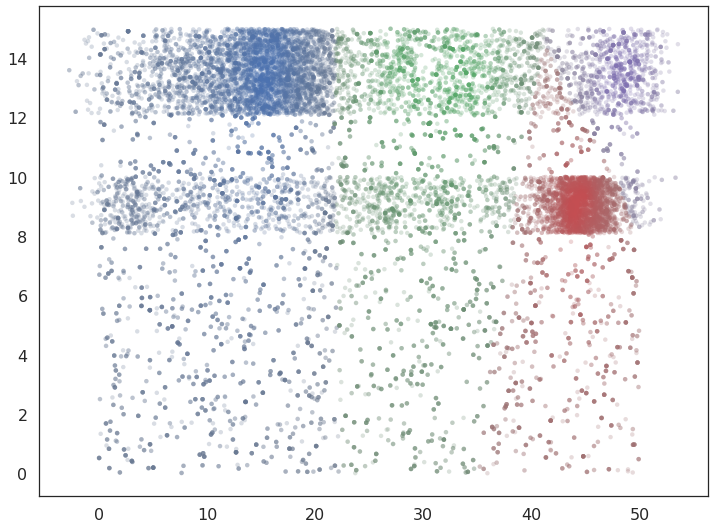

In [82]:
plt.figure(figsize=(12,9))
exemplar_dict = {c:exemplars(c,tree) for c in tree._select_clusters()}
colors = np.empty((Data_use.shape[0], 3))
for x in range(Data_use.shape[0]):
    membership_vector = dist_membership_vector(x, exemplar_dict, Data_use)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(X_position_cl,A_amplitude_cl, c=colors, **plot_kwds);

In [83]:
def max_lambda_val(cluster, tree):
    cluster_tree = tree[tree['child_size'] > 1]
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster)
    max_lambda = 0.0
    for leaf in leaves:
        max_lambda = max(max_lambda, 
                         tree['lambda_val'][tree['parent'] == leaf].max())
    return max_lambda

def points_in_cluster(cluster, tree):
    leaves = hdbscan.plots._recurse_leaf_dfs(tree, cluster)
    return leaves

In [84]:
def merge_height(point, cluster, tree, point_dict):
    cluster_row = tree[tree['child'] == cluster]
    cluster_height = cluster_row['lambda_val'][0]
    if point in point_dict[cluster]:
        merge_row = tree[tree['child'] == float(point)][0]
        return merge_row['lambda_val']
    else:
        while point not in point_dict[cluster]:
            parent_row = tree[tree['child'] == cluster]
            cluster = parent_row['parent'].astype(np.float64)[0]
        for row in tree[tree['parent'] == cluster]:
            child_cluster = float(row['child'])
            if child_cluster == point:
                return row['lambda_val']
            if child_cluster in point_dict and point in point_dict[child_cluster]:
                return row['lambda_val']

In [85]:
def per_cluster_scores(point, cluster_ids, tree, max_lambda_dict, point_dict):
    result = {}
    point_row = tree[tree['child'] == point]
    point_cluster = float(point_row[0]['parent'])
    max_lambda = max_lambda_dict[point_cluster] + 1e-8 # avoid zero lambda vals in odd cases
    
    for c in cluster_ids:
        height = merge_height(point, c, tree, point_dict)
        result[c] = (max_lambda / (max_lambda - height))
    return result

In [86]:
def outlier_membership_vector(point, cluster_ids, tree, 
                              max_lambda_dict, point_dict, softmax=True):
    if softmax:
        result = np.exp(np.array(list(per_cluster_scores(point, 
                                                         cluster_ids, 
                                                         tree,
                                                         max_lambda_dict,
                                                         point_dict
                                                        ).values())))
        result[~np.isfinite(result)] = np.finfo(np.double).max
    else:
        result = np.array(list(per_cluster_scores(point, 
                                                  cluster_ids, 
                                                  tree,
                                                  max_lambda_dict,
                                                  point_dict
                                                 ).values()))
    result /= result.sum()
    return result

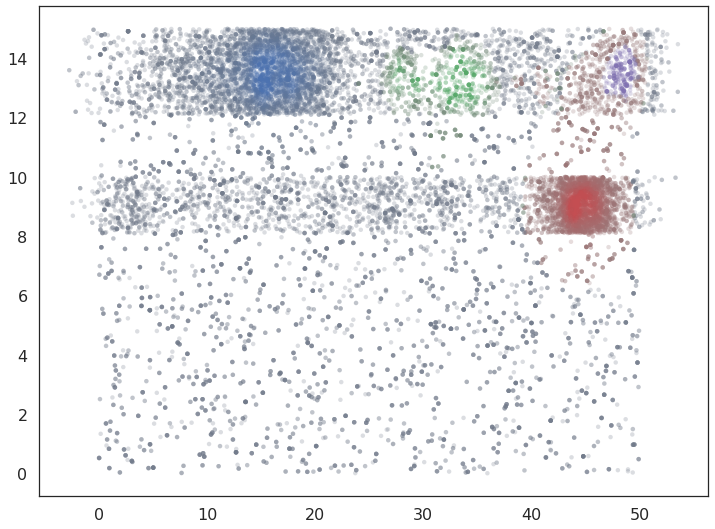

In [87]:
plt.figure(figsize=(12,9))
cluster_ids = tree._select_clusters()
raw_tree = tree._raw_tree
all_possible_clusters = np.arange(Data_use.shape[0], raw_tree['parent'].max() + 1).astype(np.float64)
max_lambda_dict = {c:max_lambda_val(c, raw_tree) for c in all_possible_clusters}
point_dict = {c:set(points_in_cluster(c, raw_tree)) for c in all_possible_clusters}
colors = np.empty((Data_use.shape[0], 3))
for x in range(Data_use.shape[0]):
    membership_vector = outlier_membership_vector(x, cluster_ids, raw_tree, 
                                                  max_lambda_dict, point_dict, False)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(X_position_cl,A_amplitude_cl, c=colors, **plot_kwds);

In [95]:
def combined_membership_vector(point, data, tree, exemplar_dict, cluster_ids,
                               max_lambda_dict, point_dict, softmax=False):
    raw_tree = tree._raw_tree
    dist_vec = dist_membership_vector(point, exemplar_dict, data, softmax)
    outl_vec = outlier_membership_vector(point, cluster_ids, raw_tree, 
                                         max_lambda_dict, point_dict, softmax)
    result = dist_vec * outl_vec
    result /= result.sum()
    return result

/home/hope/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


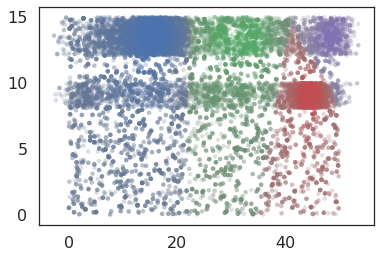

In [97]:
colors = np.empty((Data_use.shape[0], 3))
for x in range(Data_use.shape[0]):
    membership_vector = combined_membership_vector(x, Data_use, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(X_position_cl,A_amplitude_cl, c=colors, **plot_kwds);

In [98]:
def prob_in_some_cluster(point, tree, cluster_ids, point_dict, max_lambda_dict):
    heights = []
    for cluster in cluster_ids:
        heights.append(merge_height(point, cluster, tree._raw_tree, point_dict))
    height = max(heights)
    nearest_cluster = cluster_ids[np.argmax(heights)]
    max_lambda = max_lambda_dict[nearest_cluster]
    return height / max_lambda

/home/hope/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


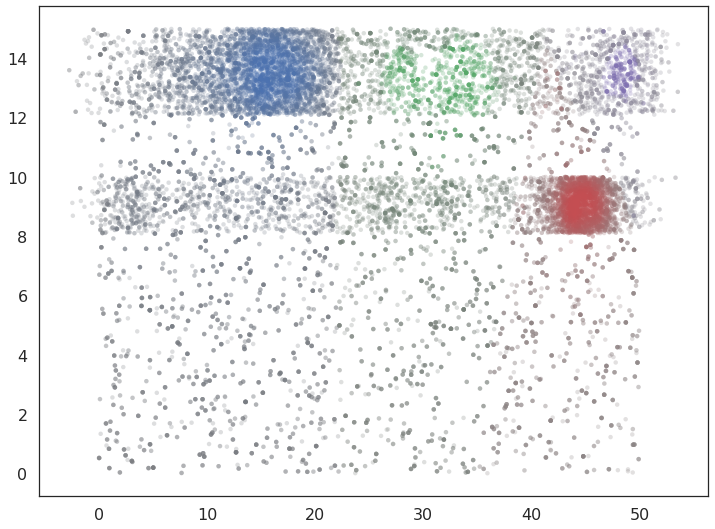

In [100]:
plt.figure(figsize=(12,9))
colors = np.empty((Data_use.shape[0], 3))
for x in range(Data_use.shape[0]):
    membership_vector = combined_membership_vector(x, Data_use, tree, exemplar_dict, cluster_ids,
                                                   max_lambda_dict, point_dict, False)
    membership_vector *= prob_in_some_cluster(x, tree, cluster_ids, point_dict, max_lambda_dict)
    color = np.argmax(membership_vector)
    saturation = membership_vector[color]
    colors[x] = sns.desaturate(pal[color], saturation)
plt.scatter(X_position_cl,A_amplitude_cl, c=colors, **plot_kwds);

In [101]:
hdbscan.HDBSCAN?

In [102]:
clusterer.cluster_persistence_

array([0.2424132 , 0.02109554, 0.40445006, 0.00936114])

In [105]:
clusterer.condensed_tree_.to_pandas().head()

,parent,child,lambda_val,child_size
0,19325,1621,0.127519,1
1,19325,1781,0.127519,1
2,19325,2203,0.127519,1
3,19325,3939,0.127519,1
4,19325,3663,0.127519,1


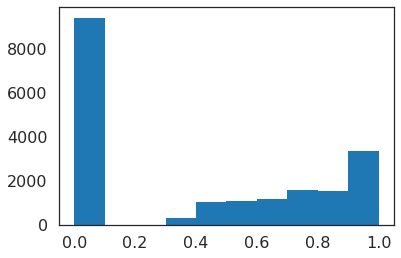

In [110]:
plt.hist(clusterer.probabilities_,bins=10);

In [155]:
indx = np.where(clusterer.labels_>-1)

In [156]:
indx[0]

array([    2,     3,     5, ..., 19318, 19320, 19321])

In [157]:
X_clusters = X_position_cl[indx[0]]
A_clusters = A_amplitude_cl[indx[0]]

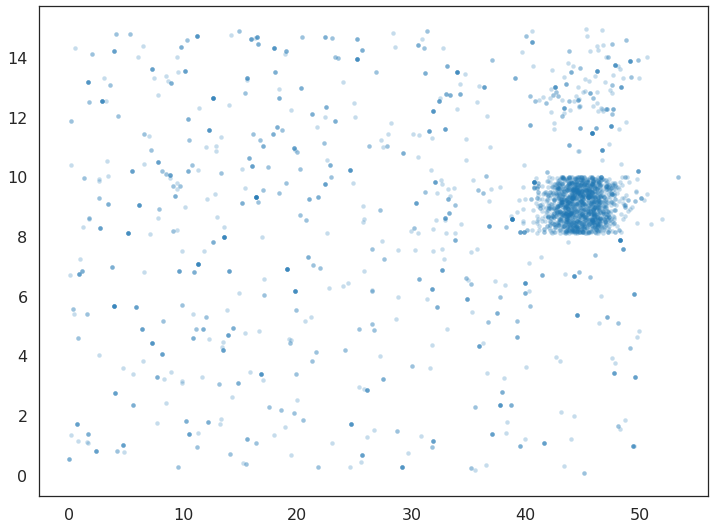

In [158]:
plt.figure(figsize=(12,9))
plt.scatter(X_clusters,A_clusters,**plot_kwds)

In [148]:
clusterer.labels_


array([-1, -1,  2, ..., -1, -1, -1])